In [17]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt


In [29]:
DATA_DIR = Path(".")  # ou Path("caminho/para/seus/arquivos")

MAMMO_PKL = DATA_DIR / "mammo_embeddings.pkl"
LATENT_CSV = DATA_DIR / "data/matrices/autoencoder_latent_space.csv"
GENETIC_LATENT_CSV = DATA_DIR / "data/matrices/autoencoder_latent_space.csv"

assert MAMMO_PKL.exists(), f"Não achei {MAMMO_PKL}"
assert LATENT_CSV.exists(), f"Não achei {LATENT_CSV}"
assert GENETIC_LATENT_CSV.exists(), f"Não achei {GENETIC_LATENT_CSV}"

print("OK: arquivos encontrados")


OK: arquivos encontrados


In [19]:
with open(MAMMO_PKL, "rb") as f:
    mammo_obj = pickle.load(f)

type(mammo_obj), (mammo_obj.head() if hasattr(mammo_obj, "head") else list(mammo_obj)[:3])


(pandas.core.frame.DataFrame,
   patient_id split lesion_type laterality view series_variant  \
 0    P_00038  Test        Calc       LEFT   CC             _0   
 1    P_00038  Test        Calc       LEFT   CC             _1   
 2    P_00038  Test        Calc       LEFT  MLO             _0   
 3    P_00038  Test        Calc       LEFT  MLO             _1   
 4    P_00038  Test        Calc      RIGHT   CC             _0   
 
                                            embedding  
 0  [tensor(0.0068), tensor(0.1932), tensor(0.), t...  
 1  [tensor(0.), tensor(0.2228), tensor(0.), tenso...  
 2  [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
 3  [tensor(0.), tensor(0.1231), tensor(0.), tenso...  
 4  [tensor(0.0029), tensor(0.2364), tensor(0.0077...  )

In [22]:
if isinstance(mammo_obj, pd.DataFrame):
    print(mammo_obj.shape)
    print(mammo_obj.columns)
    mammo_df = mammo_obj.copy()
else:
    mammo_df = None
    print("mammo_embeddings.pkl não é DataFrame — vou usar só o latent CSV como base.")


(6671, 7)
Index(['patient_id', 'split', 'lesion_type', 'laterality', 'view',
       'series_variant', 'embedding'],
      dtype='object')


In [23]:
img_latent = pd.read_csv(LATENT_CSV)
print(img_latent.shape)
img_latent.head()


(149, 4)


,pgs_id,z1,z2,z3
0,PGS000001,-0.422740,0.464718,0.166091
1,PGS000002,-0.027997,0.495385,0.165780
2,PGS000003,-0.272683,0.492684,0.162441
3,PGS000004,0.471293,0.303873,-0.094151
4,PGS000005,0.485579,0.376037,-0.084380


In [24]:
def guess_id_column(df):
    candidates = ["image_id", "series_uid", "study_uid", "subject_id", "patient_id", "id", "join_id"]
    lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in lower:
            return lower[c]
    for c in df.columns:
        if "id" in c.lower() or "uid" in c.lower():
            return c
    return None

img_id_col = guess_id_column(img_latent)
print("ID col (img):", img_id_col)
assert img_id_col is not None, "Não achei coluna ID no autoencoder_latent_space.csv"


ID col (img): pgs_id


In [25]:
img_latent = img_latent.rename(columns={img_id_col: "join_id"})
img_feat_cols = [c for c in img_latent.columns if c != "join_id"]

print("N img feats:", len(img_feat_cols))


N img feats: 3


In [30]:
gen_latent = None
if GENETIC_LATENT_CSV.exists():
    gen_latent = pd.read_csv(GENETIC_LATENT_CSV)
    gen_id_col = guess_id_column(gen_latent)
    print("ID col (gen):", gen_id_col)
    gen_latent = gen_latent.rename(columns={gen_id_col: "join_id"})
    gen_feat_cols = [c for c in gen_latent.columns if c != "join_id"]
    print("Gen latent:", gen_latent.shape, "N feats:", len(gen_feat_cols))
else:
    print("Sem genetic_latent_space.csv — ok, seguimos sem genética.")


ID col (gen): pgs_id
Gen latent: (149, 4) N feats: 3


In [31]:
prs = None
if PRS_CSV.exists():
    prs = pd.read_csv(PRS_CSV)
    prs_id_col = guess_id_column(prs)
    prs = prs.rename(columns={prs_id_col: "join_id"})
    # tenta achar a coluna score
    cand = [c for c in prs.columns if c != "join_id"]
    score_col = None
    for c in cand:
        if "prs" in c.lower() or "score" in c.lower() or "pgs" in c.lower():
            score_col = c
            break
    if score_col is None:
        num_cols = prs.select_dtypes(include=[np.number]).columns.tolist()
        num_cols = [c for c in num_cols if c != "join_id"]
        if len(num_cols):
            score_col = num_cols[0]
    if score_col is None:
        raise ValueError("Não achei coluna de PRS numérica.")
    prs = prs[["join_id", score_col]].rename(columns={score_col: "prs_score"})
    print("PRS:", prs.shape)
else:
    print("Sem prs.csv — ok.")


Sem prs.csv — ok.


In [32]:
df = img_latent.copy()

if gen_latent is not None:
    df = df.merge(gen_latent, on="join_id", how="inner")

if prs is not None:
    df = df.merge(prs, on="join_id", how="inner")

print("FINAL DF:", df.shape)
df.head()


FINAL DF: (149, 7)


,join_id,z1_x,z2_x,z3_x,z1_y,z2_y,z3_y
0,PGS000001,-0.422740,0.464718,0.166091,-0.422740,0.464718,0.166091
1,PGS000002,-0.027997,0.495385,0.165780,-0.027997,0.495385,0.165780
2,PGS000003,-0.272683,0.492684,0.162441,-0.272683,0.492684,0.162441
3,PGS000004,0.471293,0.303873,-0.094151,0.471293,0.303873,-0.094151
4,PGS000005,0.485579,0.376037,-0.084380,0.485579,0.376037,-0.084380


In [33]:
df.to_csv("final_representation_dataset.csv", index=False)
print("Salvo: final_representation_dataset.csv")


Salvo: final_representation_dataset.csv


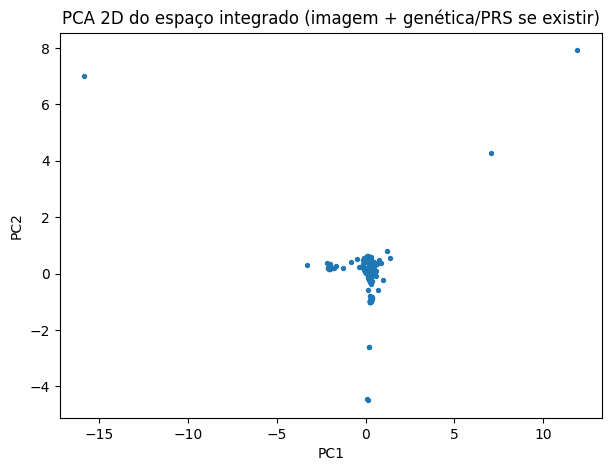

In [34]:
X = df.drop(columns=["join_id"]).values
X = StandardScaler().fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
Z = pca2.fit_transform(X)

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], s=8)
plt.title("PCA 2D do espaço integrado (imagem + genética/PRS se existir)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [35]:
k = 10
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = km.fit_predict(X)

df["cluster"] = clusters
df["cluster"].value_counts().sort_index()


cluster
0    27
1     1
2     1
3    16
4    30
5     1
6     2
7    68
8     1
9     2
Name: count, dtype: int64

In [38]:
import numpy as np

def get_numeric_feature_cols(df, exclude=("join_id", "id", "patient_id", "series_uid")):
    exclude_set = set(exclude)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in exclude_set]

def guess_latent_cols_by_prefix(df, prefixes=("z", "z_", "img_z", "gen_z", "latent", "ae_", "enc_")):
    cols = []
    for c in df.columns:
        lc = c.lower()
        if any(lc.startswith(p) for p in prefixes) and pd.api.types.is_numeric_dtype(df[c]):
            cols.append(c)
    return cols

def safe_print_cols(df, n=30):
    print("Columns sample:", df.columns.tolist()[:n])
    print("Numeric cols sample:", df.select_dtypes(include=[np.number]).columns.tolist()[:n])


In [39]:
print("DF shape:", df.shape)
safe_print_cols(df, n=50)


DF shape: (149, 8)
Columns sample: ['join_id', 'z1_x', 'z2_x', 'z3_x', 'z1_y', 'z2_y', 'z3_y', 'cluster']
Numeric cols sample: ['z1_x', 'z2_x', 'z3_x', 'z1_y', 'z2_y', 'z3_y', 'cluster']


In [40]:
img_cols = get_numeric_feature_cols(img_latent, exclude=("join_id",))
gen_cols = get_numeric_feature_cols(gen_latent, exclude=("join_id",))

print("img cols:", img_cols[:10], " ... total:", len(img_cols))
print("gen cols:", gen_cols[:10], " ... total:", len(gen_cols))


img cols: ['z1', 'z2', 'z3']  ... total: 3
gen cols: ['z1', 'z2', 'z3']  ... total: 3


In [41]:
from sklearn.preprocessing import StandardScaler

X_img = StandardScaler().fit_transform(img_latent[img_cols].values)
X_gen = StandardScaler().fit_transform(gen_latent[gen_cols].values)

print(X_img.shape, X_gen.shape)


(149, 3) (149, 3)


In [42]:
img_latent_ren = img_latent.copy()
gen_latent_ren = gen_latent.copy()

# pega só numéricas
img_cols = get_numeric_feature_cols(img_latent_ren, exclude=("join_id",))
gen_cols = get_numeric_feature_cols(gen_latent_ren, exclude=("join_id",))

img_latent_ren = img_latent_ren[img_cols].add_prefix("img_")
gen_latent_ren = gen_latent_ren[gen_cols].add_prefix("gen_")

# Não merge por ID (cohort diferente). Só mantém separado.
print(img_latent_ren.shape, gen_latent_ren.shape)


(149, 3) (149, 3)


In [43]:
X_img = StandardScaler().fit_transform(img_latent_ren.values)
X_gen = StandardScaler().fit_transform(gen_latent_ren.values)


In [44]:
print("img_feat_cols:", img_feat_cols[:20])
print("df columns contains z1?", "z1" in df.columns)
print("df columns sample:", df.columns.tolist()[:50])


img_feat_cols: ['z1', 'z2', 'z3']
df columns contains z1? False
df columns sample: ['join_id', 'z1_x', 'z2_x', 'z3_x', 'z1_y', 'z2_y', 'z3_y', 'cluster']


In [45]:
print(img_latent.columns.tolist()[:30])
print(gen_latent.columns.tolist()[:30])


['join_id', 'z1', 'z2', 'z3']
['join_id', 'z1', 'z2', 'z3']
